In [1]:
import os
import math
import random
import numpy as np
import random
import torch

import draw,utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
Train_filename = "Train.npy"
Valid_filename = "Valid.npy"
Modelname = "GLPmerge_cigfacies_L2SSIM"

In [3]:
num_sample = 2000
root_path = os.path.abspath(".")
dataset_name = 'synthetic'
dataset_path = os.path.join(root_path, "dataset",dataset_name)
train_dataset_path = os.path.join(dataset_path, "syn_datasets_cigfacies")
ciglabel_path = os.path.join(dataset_path, "syn_datasets_localhorizon/")

if os.path.exists(os.path.join(dataset_path,Train_filename)) is False:
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    train_set_ratio = 0.75
    num_data_sample = len(sample_name_list)
    # 打乱数据集
    random.shuffle(sample_name_list)

    # 训练集/验证集划分
    valid_num = int(num_data_sample * (1-train_set_ratio))
    valid_list = random.sample(sample_name_list, valid_num)

    samples_train,samples_valid = [],[]
    for sample_name in sample_name_list[:num_sample]:
        if sample_name not in valid_list:
            samples_train.append(sample_name)
        else:
            samples_valid.append(sample_name)
            
    print(f'Training num：{len(samples_train)}')
    print(f'Validation num：{len(samples_valid)}')
    
    np.save(os.path.join(dataset_path,Train_filename), samples_train)
    np.save(os.path.join(dataset_path,Valid_filename), samples_valid)

Training num：1500
Validation num：500


In [6]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU num: {num_GPU}")
print(f"Platform: {device}")
root_path = os.path.abspath('.')

GPU num: 1
Platform: cuda


In [7]:
samples_train = np.load(os.path.join(dataset_path, Train_filename), allow_pickle=True)
samples_valid = np.load(os.path.join(dataset_path, Valid_filename), allow_pickle=True)
print(f"Training num: {len(samples_train)}")
print(f"Validation num: {len(samples_valid)}")

train_sample_path = os.path.join(dataset_path, "syn_datasets_cigfacies")
input_attr_list, input_attr_list2 = ["seis"], ["cigfacies"]  
input_attr_list3,input_attr_list4 = ["normal"], ["linearity"]
output_attr_list, output_attr_list2 = ["rgt"], ["unconformities"]

Training num: 1500
Validation num: 500


In [8]:
train_data =  utils.build_dataset_cigfacies(samples_train, train_sample_path, 'Train',
                                            input_attr_list=input_attr_list,input_attr_list2=input_attr_list2,
                                            input_attr_list3=input_attr_list3,input_attr_list4=input_attr_list4,
                                            output_attr_list=output_attr_list, output_attr_list2=output_attr_list2)
valid_data =  utils.build_dataset_cigfacies(samples_valid, train_sample_path, 'Valid', 
                                            input_attr_list=input_attr_list,input_attr_list2=input_attr_list2,
                                            input_attr_list3=input_attr_list3,input_attr_list4=input_attr_list4,
                                            output_attr_list=output_attr_list, output_attr_list2=output_attr_list2)

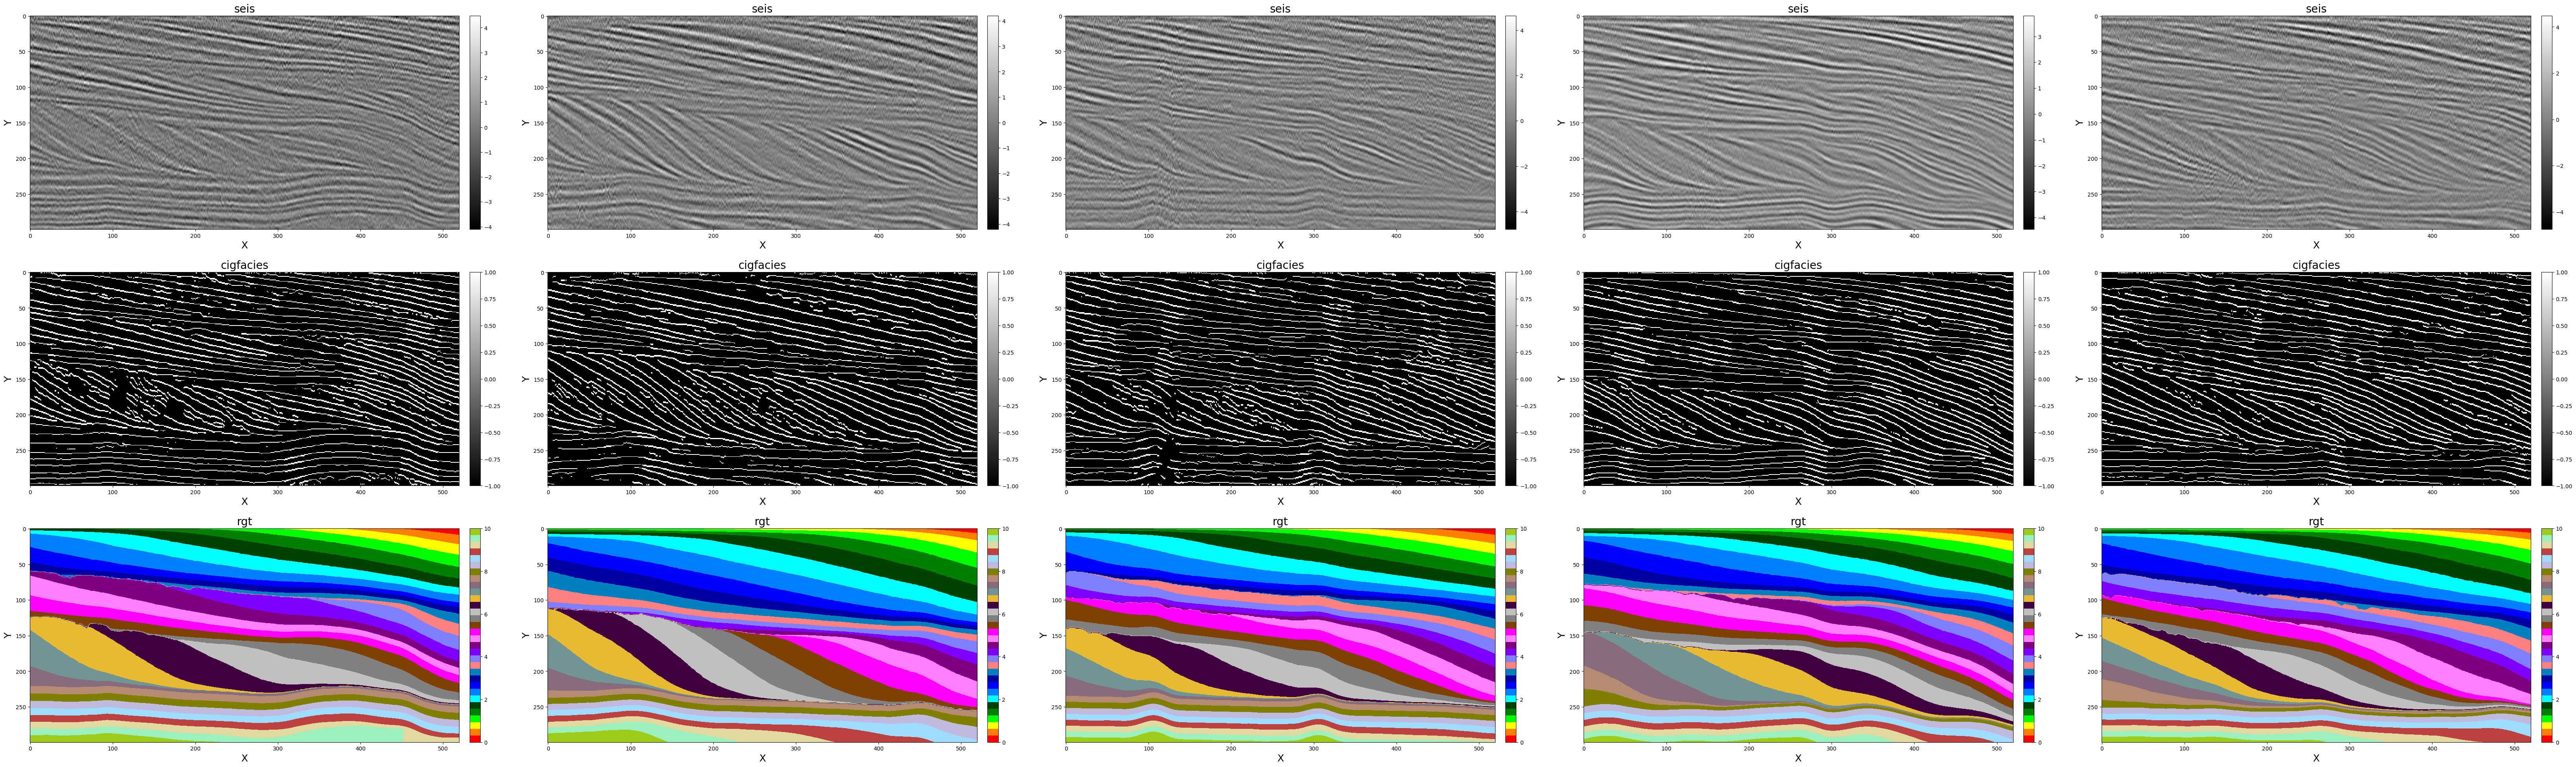

In [7]:
# plot
idxs = np.random.randint(0, len(train_data), size=5) 
batch_samples = [train_data[i] for i in idxs]
draw_attr_list = input_attr_list + input_attr_list2 + output_attr_list
draw.draw_samples(batch_samples, draw_attr_list, cmap=["gray","gray",utils.getStrataColors()],
                  methods=["bilinear","nearest","bilinear"])

In [8]:
from GLP.model import GLPDepth_merge,GLPDepth 
# model = GLPDepth(max_depth=10,is_train=True)
model = GLPDepth_merge(max_depth=10,is_train=True)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    model = model.to(device) 
    
# model.load_state_dict(torch.load("./checkpoints/GLP_cigfacies_L2SSIM/checkpoint-epoch100.pth")['state_dict'])
# model.load_state_dict(torch.load("./checkpoints/GLP_cigfacies_L2SSIM/checkpoint-epoch100.pth")['state_dict'])
                                 
# model save
checkpoint_path = os.path.join('checkpoints', Modelname)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
print(f"model load path: {checkpoint_path}")

/home/huig/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Loads checkpoint by local backend from path: ./GLP/weights/mit_b4.pth
The model and loaded state dict do not match exactly

size mismatch for patch_embed1.proj.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 7, 7]).
unexpected key in source state_dict: head.weight, head.bias

模型读取路径: checkpoints/GLPmerge_L2SSIM_2


In [9]:
# 定义训练参数
param = {}
param['epochs'] = 101     
param['batch_size'] = 24   
param['lr'] = 1e-2          
# SGD
param['gamma'] = 0.9      
param['step_size'] = 50  
param['momentum'] = 0.8    
# Adam
param['lr_factor'] = 0.5 
param['lr_patience'] = 2 
param['weight_decay'] = 0 

param['optimizer_type'] = 'Adam' 
param['checkpoint_path'] = checkpoint_path
param['disp_inter'] = 1 
param['save_inter'] = 10 

Epoch:0, Training Loss:1.083557 <0.7774+0.3061+0.0000+0.0000> Validation Loss:1.034354 Learning rate: 0.010000
Epoch:1, Training Loss:0.429773 <0.2478+0.1820+0.0000+0.0000> Validation Loss:0.275761 Learning rate: 0.010000
Epoch:2, Training Loss:0.168056 <0.0956+0.0725+0.0000+0.0000> Validation Loss:0.147673 Learning rate: 0.010000
Epoch:3, Training Loss:0.141696 <0.0790+0.0627+0.0000+0.0000> Validation Loss:0.183718 Learning rate: 0.010000
Epoch:4, Training Loss:0.119305 <0.0629+0.0564+0.0000+0.0000> Validation Loss:0.111873 Learning rate: 0.010000
Epoch:5, Training Loss:0.108790 <0.0542+0.0546+0.0000+0.0000> Validation Loss:0.110644 Learning rate: 0.010000
Epoch:6, Training Loss:0.095310 <0.0459+0.0494+0.0000+0.0000> Validation Loss:0.114827 Learning rate: 0.010000
Epoch:7, Training Loss:0.091668 <0.0448+0.0469+0.0000+0.0000> Validation Loss:0.086186 Learning rate: 0.010000
Epoch:8, Training Loss:0.079644 <0.0359+0.0437+0.0000+0.0000> Validation Loss:0.079705 Learning rate: 0.010000
E

Epoch:74, Training Loss:0.022463 <0.0072+0.0152+0.0000+0.0000> Validation Loss:0.034695 Learning rate: 0.001250
Epoch:75, Training Loss:0.022503 <0.0072+0.0153+0.0000+0.0000> Validation Loss:0.033802 Learning rate: 0.001250
Epoch:76, Training Loss:0.022263 <0.0071+0.0152+0.0000+0.0000> Validation Loss:0.034773 Learning rate: 0.001250
Epoch:77, Training Loss:0.022491 <0.0071+0.0154+0.0000+0.0000> Validation Loss:0.032762 Learning rate: 0.001250
Epoch:78, Training Loss:0.020775 <0.0065+0.0143+0.0000+0.0000> Validation Loss:0.033374 Learning rate: 0.001250
Epoch:79, Training Loss:0.019749 <0.0061+0.0136+0.0000+0.0000> Validation Loss:0.032372 Learning rate: 0.001250
Epoch:80, Training Loss:0.019767 <0.0062+0.0135+0.0000+0.0000> Validation Loss:0.032078 Learning rate: 0.001250
Epoch:81, Training Loss:0.019362 <0.0060+0.0133+0.0000+0.0000> Validation Loss:0.030415 Learning rate: 0.001250
Epoch:82, Training Loss:0.018982 <0.0059+0.0131+0.0000+0.0000> Validation Loss:0.036158 Learning rate: 0

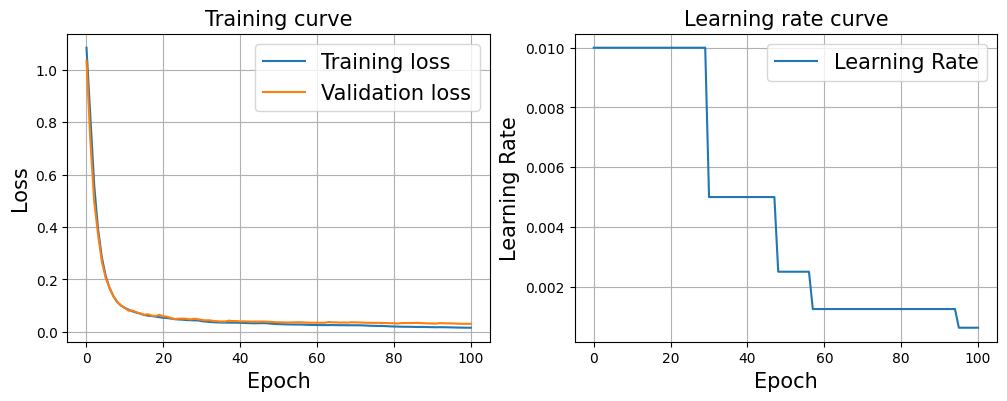

log has saved


In [10]:
model = utils.train_valid_GLP_cigfacies(param, model, train_data, valid_data,ciglabel_dir = ciglabel_path,
                                        Loss="L2",CIGLoss_type="L1",Training_stage="step-1",
                                        input_attrs=input_attr_list, input_attrs2=input_attr_list2,
                                        input_attrs3=input_attr_list3,input_attrs4=input_attr_list4,
                                        output_attrs=output_attr_list,output_attrs2=output_attr_list2, plot=True)

In [11]:
quit()